# Hand Gesture Recognition

## A Convolutional Neural Network to identify hand gestures

The data set is generated using the python script 'get_gestures.py'. It uses Opencv to capture gesture images from laptop webcam. (more details are given in the readme file)

This project is the first part of the "Webcam-based Hand Cricket", which uses webcam to identify hand gestures. 
    
    The game description:
        1. Two players (Batsman and Bowler)
        2. Each gesture represents number of runs for the batsman
        3. If batsman's and bowler's gestures match - the batsman is out
        4. Each player has to bowl and bat in each match
        5. Who ever scores more is the winner

In this part, I collected 200 images of each gesture and 100 images without hand. Out of 200/100 of each set a 20% was used as test set. This notebook contains images of gestures, the dataset class to load the images and training, testing of the convolutional neural network model to classify the gestures.

In [1]:
# Library imports
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Looking at the gestures

Images are loaded using Pillow and are displayed using matplotlib.

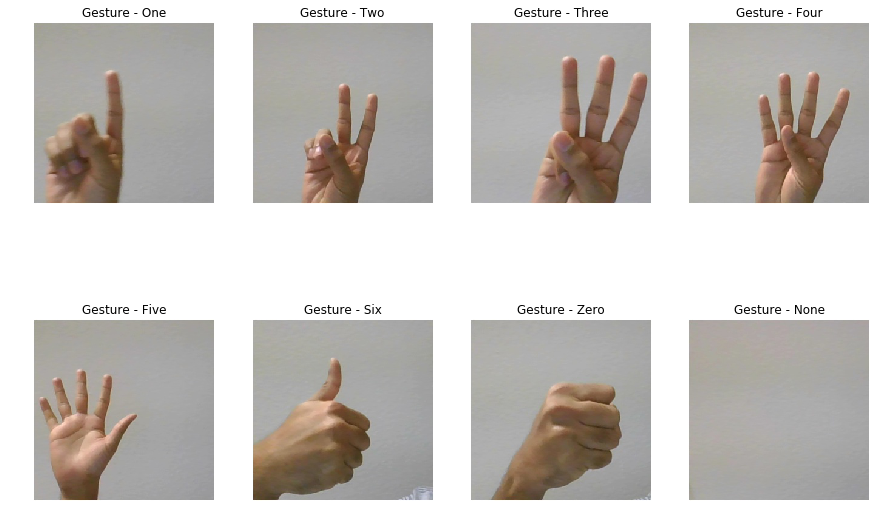

In [55]:
img0 = Image.open('data/zero/zero_100_TR.jpg')
img1 = Image.open('data/one/one_100_TR.jpg')
img2 = Image.open('data/two/two_100_TR.jpg')
img3 = Image.open('data/three/three_100_TR.jpg')
img4 = Image.open('data/four/four_100_TR.jpg')
img5 = Image.open('data/five/five_100_TR.jpg')
img6 = Image.open('data/six/six_100_TR.jpg')
img7 = Image.open('data/none/none_100_TR.jpg')


fig = plt.figure(figsize=(15, 10))

plt.subplot(241)
plt.imshow(img1)
plt.axis('off')
plt.title(f'Gesture - One')

plt.subplot(242)
plt.imshow(img2)
plt.axis('off')
plt.title(f'Gesture - Two')

plt.subplot(243)
plt.imshow(img3)
plt.axis('off')
plt.title(f'Gesture - Three')

plt.subplot(244)
plt.imshow(img4)
plt.axis('off')
plt.title(f'Gesture - Four')

plt.subplot(245)
plt.imshow(img5)
plt.axis('off')
plt.title(f'Gesture - Five')

plt.subplot(246)
plt.imshow(img6)
plt.axis('off')
plt.title(f'Gesture - Six')

plt.subplot(247)
plt.imshow(img0)
plt.axis('off')
plt.title(f'Gesture - Zero')

plt.subplot(248)
plt.imshow(img7)
plt.axis('off')
plt.title(f'Gesture - None')

plt.show()

#### As explained each gesture represents the runs hit by the batsman. The images are self explanatory. 

Now two dictionaries to map class names to scores and score to class names are as shown below.

In [2]:
class_dict = {
    'zero' : 0,
    'one' : 1,
    'two' : 2,
    'three' : 3, 
    'four' : 4,
    'five' : 5,
    'six' : 6,
    'none' : 7
}
class_map = {
    0 : 'zero',
    1 : 'one',
    2 : 'two',
    3 : 'three',
    4 : 'four',
    5 : 'five',
    6 : 'six',
    7 : 'none'
}

### Dataset

In PyTorch in order to simplify the training and evaluating procedures it is suggested that the data is loaded using a Dataset Class and DataLoader. To achieve that I am using the below written class which is inherited from the Pytorch Dataset Object.

In [3]:
class HandGestureDataset(torch.utils.data.dataset.Dataset):
    """
        data_path : path to the folder containing images
        train : to specifiy to load training or testing data 
        transform : Pytorch transforms [required - ToTensor(), optional - rotate, flip]
    """
    def __init__(self, data_path, train = True, transform = None):
        
        self.data_path = data_path
        self.train = train
        self.data, self.targets = self.load(self.data_path, train)
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = Image.open(self.data[idx])
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.targets[idx]
        
    def load(self, data_path, train):
        images = []
        targets = []
        for class_name in os.listdir(data_path):
            target = class_dict[class_name]
            curr_path = os.path.join(data_path, class_name)
            for image_name in os.listdir(curr_path):
                if 'TR' in image_name and train:
                    images.append(os.path.join(curr_path, image_name))
                    targets.append(target)
                elif 'TE' in image_name and not train:
                    images.append(os.path.join(curr_path, image_name))
                    targets.append(target)
        
        indices = np.random.permutation(len(images))
        images = np.array(images)[indices]
        targets = np.array(targets, dtype=np.int64)[indices]
        return images, targets
    

### Functions to train and validate the network

In [4]:
def get_accuracy(output, target):
    predictions = torch.argmax(output.data, 1)
    accuracy = (predictions == target).sum().item() / target.size(0)
    return accuracy

def validate(model, device, loader, loss_criterion):
    model.eval()
    losses = []
    accuracies = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device)
        
        out = model(image)
        
        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)
    
    return np.mean(losses), np.mean(accuracies)

def execute_trainstep(model, device, loader, loss_criterion, optimizer):
    model.train()
    losses = []
    accuracies = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        out = model(image)
        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(losses), np.mean(accuracies)

def train(epochs, model, device, train_loader, valid_loader, loss_criterion, optimizer):
    train_losses = []
    valid_losses = []
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(1, epochs+1):
        
        start = time.time()
        
        train_loss, train_accuracy = execute_trainstep(model, device, train_loader, loss_criterion, optimizer)
        valid_loss, valid_accuracy = validate(model, device, valid_loader, loss_criterion)
        
        end = time.time()
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f"""\nEpoch {epoch}/{epochs} Time : {end-start:.2f}s 
                Training Loss : {train_losses[-1]:.6f} Validation Loss : {valid_losses[-1]:.6f}
                Training Accuracy : {train_accuracies[-1]*100:.2f} Validation Accuracy : {valid_accuracies[-1]*100:.2f}""")
        
    return train_losses, valid_losses, train_accuracies, valid_accuracies

### The Network Class

A series of Convolutional, Batchnormalisation, Pooling layers with ReLU activations and a fully connected network with dropout is used in this case to classify hand gestures.


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(
                                nn.Conv2d(3, 6, 3),
                                nn.BatchNorm2d(6, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(6, 12, 3),
                                nn.BatchNorm2d(12, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(12, 24, 3),
                                nn.BatchNorm2d(24, affine = False),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(24, 48, 3),
                                nn.BatchNorm2d(48, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
                                nn.Conv2d(48, 96, 3),
                                nn.BatchNorm2d(96, affine = False),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2),
        )
        self.classifier = nn.Sequential(
                                nn.Linear(96*4*4,1000),
                                nn.Tanh(),
                                nn.Dropout(p=0.4),
                                nn.Linear(1000, 8),
                                nn.Tanh()
        )
                                
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 96*4*4)
        x = self.classifier(x)
        return x

#### Optimizer and Loss function

- 'Adam' optimizer with a learning rate of 0.001 worked in this case. 
- Categorical crossentropy loss is chosen as the Loss function

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

torch.cuda.empty_cache()

net = Net().to(device)


lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

cuda


#### Data Transformations

- The images are resized to 128x128
- Randomly Flipped horizontally with a probability of 0.5 (which is default)
- Transformed to tensors
- A batch size of 32 worked in this case

In [7]:
transformer = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                            ])

train_dataset= HandGestureDataset(data_path='data', train=True, transform= transformer)
test_dataset = HandGestureDataset(data_path='data', train=False, transform= transformer)


batch_size = 32
train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size= batch_size)
test_loader = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size= batch_size)

### Training
The model is trained for 20 epochs to achieve 100% accuracy. This is achieved after trying out different architectures and different hyperparameters (batch size, learning rate ...). Training images are used for training and Test images are used for validation during the training.


In [8]:
n_epochs = 20
train_losses, valid_losses, train_accuracies, valid_accuracies = train(n_epochs, net, device, 
                                                                       train_loader, test_loader, criterion, optimizer)


Epoch 1/20 Time : 7.97s 
                Training Loss : 1.756136 Validation Loss : 2.012435
                Training Accuracy : 16.31 Validation Accuracy : 25.89

Epoch 2/20 Time : 5.96s 
                Training Loss : 1.116102 Validation Loss : 2.001814
                Training Accuracy : 61.99 Validation Accuracy : 25.74

Epoch 3/20 Time : 5.84s 
                Training Loss : 0.868843 Validation Loss : 1.891461
                Training Accuracy : 76.53 Validation Accuracy : 29.61

Epoch 4/20 Time : 5.94s 
                Training Loss : 0.817174 Validation Loss : 1.561283
                Training Accuracy : 86.42 Validation Accuracy : 47.99

Epoch 5/20 Time : 5.93s 
                Training Loss : 0.763234 Validation Loss : 0.880609
                Training Accuracy : 94.32 Validation Accuracy : 87.80

Epoch 6/20 Time : 5.76s 
                Training Loss : 0.726027 Validation Loss : 1.238933
                Training Accuracy : 96.70 Validation Accuracy : 67.34

Epoch 7/20 Time

#### Loss and Accuracy plots

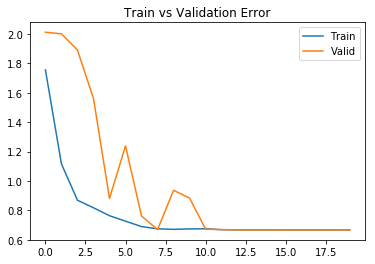

In [9]:
# loss
plt.plot(train_losses, label ='Train')
plt.plot(valid_losses, label ='Valid')
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

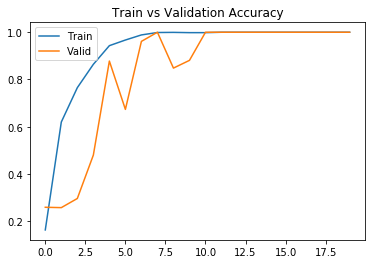

In [10]:
# Accuracy
plt.plot(train_accuracies, label ='Train')
plt.plot(valid_accuracies, label ='Valid')
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

### Saving the model

In [11]:
torch.save(net.state_dict(), './bn_hand_gesture_model_'+str(n_epochs)+'.pt')

### Testing

The saved model is loaded here and is tested with the images from testing data.

In [14]:
model = Net().to(device)
model.load_state_dict(torch.load('./bn_hand_gesture_model_20.pt'))
model.eval()

Net(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15)

In [40]:
def get_prediction(model, device, image):
    """For prediction on single image"""
    
    image = image.unsqueeze(0).to(device)
    output = model(image)
    prediction = torch.argmax(output.data, 1).cpu().item()
    return prediction

def show_img_prediction(i, dataset, device):
    
    img, target = test_dataset[i]
    pred = get_prediction(model, device, img)
    
    fig = plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.imshow(np.moveaxis(img.cpu().numpy(), 0, -1), cmap='gray')
    plt.title("Gesture")
    plt.axis("off")
    plt.text(35,150,f"Predicted {pred} | Target {target}")

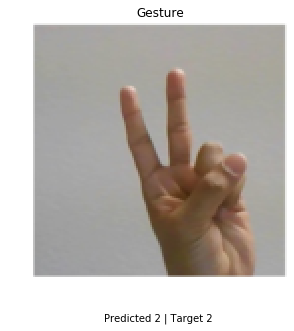

In [41]:
i = np.random.randint(100)
show_img_prediction(i, test_dataset, device)

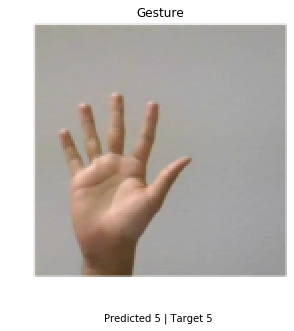

In [43]:
i = np.random.randint(100)
show_img_prediction(i, test_dataset, device)

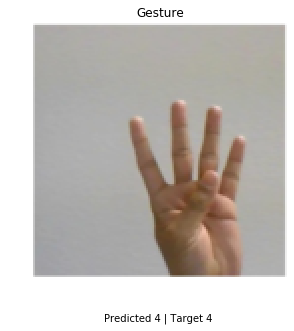

In [44]:
i = np.random.randint(100)
show_img_prediction(i, test_dataset, device)

### As shown, the model correctly predicts what a gesture represents.

##### The second part is to use this model in real-time to make predictions and use these predictions to count the score of the batsman.

## References

1. Sourav Johar, [Create a Rock Paper Scissors AI | Keras and OpenCV | Tutorial | Python](https://www.youtube.com/watch?v=0uSA3xyXlwM&feature=youtu.be)